In [1]:
# --- Notebook: 3_model_evaluation.ipynb ---

# --- 1. Import Libraries ---
import os
import sys # <--- Ensure this is here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Add the project root to the Python path
# This assumes your notebook is in 'Pneumonia_Detection_XRay/notebooks/'
# and your project root is 'Pneumonia_Detection_XRay/'
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Core ML framework import
import tensorflow as tf # <--- ENSURE THIS IS PRESENT

# Import functions from your custom src modules
from src.data_processing import get_image_data_generators, get_class_names
from src.prediction import load_pneumonia_model

# Scikit-learn for evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay

print(f"TensorFlow version: {tf.__version__}")
print("Libraries imported successfully (using src modules).")

TensorFlow version: 2.19.0
Libraries imported successfully (using src modules).


In [2]:
# --- 2. Define Data Paths (Consistent with previous notebooks) ---
base_dir = '../data/chest_xray' # Relative path from notebooks folder

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Define Model Paths
MODEL_PATH = '../models/final_best_model.h5'
HISTORY_PATH = '../models/training_history.csv' # Path to your saved training history CSV

# Verify paths exist (optional, but good for debugging)
print("\n--- Verifying Paths ---")
print(f"Train directory exists: {os.path.exists(train_dir)}")
print(f"Validation directory exists: {os.path.exists(val_dir)}")
print(f"Test directory exists: {os.path.exists(test_dir)}")
print(f"Model file exists: {os.path.exists(MODEL_PATH)}")
print(f"History file exists: {os.path.exists(HISTORY_PATH)}")
print("-" * 40)


--- Verifying Paths ---
Train directory exists: True
Validation directory exists: True
Test directory exists: True
Model file exists: True
History file exists: True
----------------------------------------


In [3]:
# --- 3. Prepare Test Data (using src.data_processing) ---

# Define Image Size and Batch Size (consistent with training) - THESE MUST BE PRESENT
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# ResNet50's preprocess_input function (same as used during training) - THIS MUST BE PRESENT
preprocess_input = tf.keras.applications.resnet50.preprocess_input

print("\n--- Setting up Test Data Generator using src.data_processing ---")
# Call the function. We only need the test_generator here, so others are _
# train_dir, val_dir, test_dir are now defined in Section 2.
_, _, test_generator = get_image_data_generators(train_dir, val_dir, test_dir, IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, preprocess_input)
# Note: train_dir and val_dir are passed but their generators are discarded.
# This ensures consistent generator creation parameters.
print("-" * 40)


--- Setting up Test Data Generator using src.data_processing ---
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
----------------------------------------


In [4]:
# --- 4. Load Trained Model (using src.prediction) ---
print("\n--- Loading Trained Model ---")
model = load_pneumonia_model(MODEL_PATH) # Call the function from src.prediction

if model is None:
    print("Failed to load model. Please check the path and file integrity.")
    print("Ensure 'final_best_model.h5' exists in the '../models/' directory.")
    exit() # Exit the notebook if model can't be loaded

print(f"Model loaded successfully from {MODEL_PATH}")
model.summary() # Optional: print model summary to verify it loaded correctly
print("-" * 40)


--- Loading Trained Model ---
Attempting to load model from: m:\Downloads\Pneumonia_Detection_XRay\Pneumonia_Detection_XRay\models\final_best_model.h5


Model loaded successfully!
Model loaded successfully from ../models/final_best_model.h5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,515 (91.98 MB)

 Trainable params: 9,443,841 (36.03 MB)

 Non-trainable params: 14,668,672 (55.96 MB)

 Optimizer params: 2 (12.00 B)

----------------------------------------


In [5]:
# --- 5. Make Predictions on Test Data ---
print("\n--- Making Predictions on Test Data ---")
# Get true labels from the test generator
y_true = test_generator.classes

# Get predictions (probabilities) from the model
y_pred_probs = model.predict(test_generator, verbose=1)

# Convert probabilities to binary class predictions (0 or 1)
# Threshold of 0.5 for sigmoid output
y_pred = (y_pred_probs > 0.5).astype(int)

# Reshape y_pred from (N, 1) to (N,) to match y_true for sklearn metrics
y_pred = y_pred.flatten()

print(f"Shape of true labels (y_true): {y_true.shape}")
print(f"Shape of predicted probabilities (y_pred_probs): {y_pred_probs.shape}")
print(f"Shape of binary predictions (y_pred): {y_pred.shape}")
print("-" * 40)



C:\Users\Melwin\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



--- Making Predictions on Test Data ---
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step
Shape of true labels (y_true): (624,)
Shape of predicted probabilities (y_pred_probs): (624, 1)
Shape of binary predictions (y_pred): (624,)
----------------------------------------


In [6]:
# --- 6. Evaluate Metrics ---
print("\n--- Model Evaluation Metrics ---")

# Get class names from the generator using src.data_processing
class_names = get_class_names(test_generator)
print(f"Class names for report: {class_names}")

# ... rest of the section (no changes needed for classification_report etc.))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)
print("-" * 40)


--- Model Evaluation Metrics ---
Class names for report: ['NORMAL', 'PNEUMONIA']

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.87      0.88      0.87       234
   PNEUMONIA       0.93      0.92      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.90      0.90       624
weighted avg       0.90      0.90      0.90       624


Confusion Matrix:
[[205  29]
 [ 31 359]]
----------------------------------------



--- Plotting Confusion Matrix ---


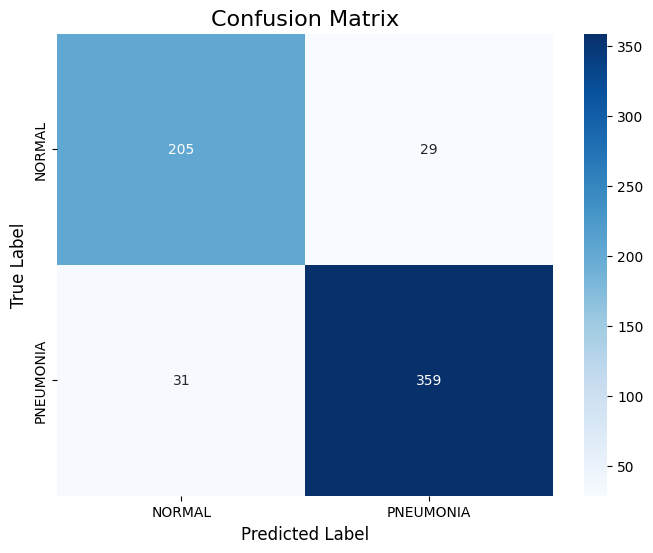

Confusion Matrix saved to ../results\confusion_matrix.png
----------------------------------------


In [7]:
# --- 7. Visualize Results ---

# Create results directory if it doesn't exist
results_dir = '../results'
os.makedirs(results_dir, exist_ok=True)

# 7.1. Plot Confusion Matrix
print("\n--- Plotting Confusion Matrix ---")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
cm_save_path = os.path.join(results_dir, 'confusion_matrix.png')
plt.savefig(cm_save_path)
plt.show()
print(f"Confusion Matrix saved to {cm_save_path}")
print("-" * 40)


--- Plotting ROC Curve ---


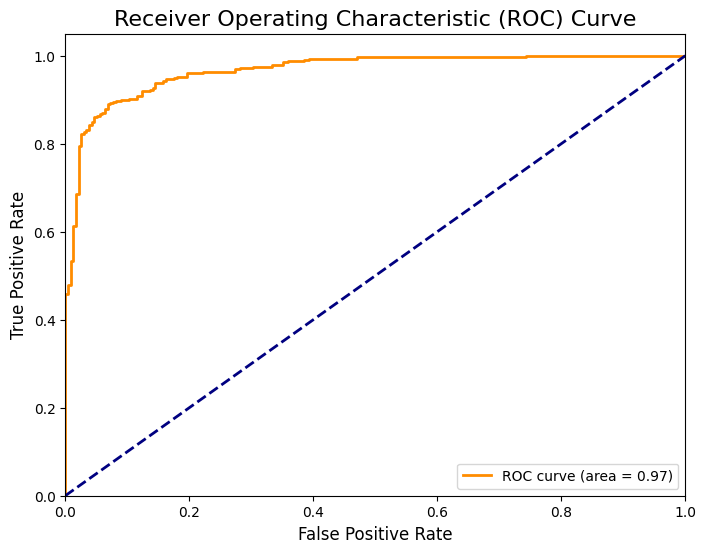

ROC Curve saved to ../results\roc_curve.png
----------------------------------------


In [8]:
# 7.2. Plot ROC Curve and calculate AUC
print("\n--- Plotting ROC Curve ---")
# For ROC Curve, we need probabilities of the positive class (Pneumonia)
# Assuming 'Pneumonia' is class 1 and 'Normal' is class 0
# y_pred_probs is already (N, 1) or (N,)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=10)
roc_save_path = os.path.join(results_dir, 'roc_curve.png')
plt.savefig(roc_save_path)
plt.show()
print(f"ROC Curve saved to {roc_save_path}")
print("-" * 40)



--- Plotting Training History ---


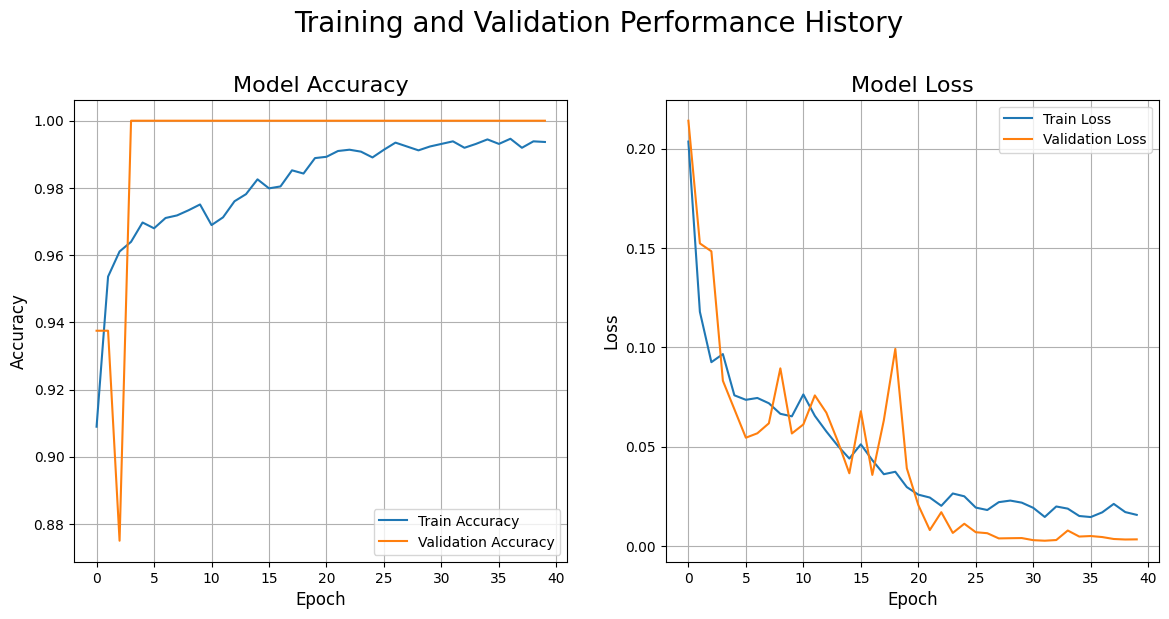

Training History plot saved to ../results\training_history.png
----------------------------------------


In [9]:
# 7.3. Plot Training History (Loss and Accuracy)
print("\n--- Plotting Training History ---")
if os.path.exists(HISTORY_PATH):
    history_df = pd.read_csv(HISTORY_PATH)

    plt.figure(figsize=(14, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history_df['accuracy'], label='Train Accuracy')
    plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True)

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history_df['loss'], label='Train Loss')
    plt.plot(history_df['val_loss'], label='Validation Loss')
    plt.title('Model Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)

    plt.suptitle('Training and Validation Performance History', fontsize=20, y=1.03)
    history_plot_save_path = os.path.join(results_dir, 'training_history.png')
    plt.savefig(history_plot_save_path)
    plt.show()
    print(f"Training History plot saved to {history_plot_save_path}")
else:
    print(f"Training history file not found at {HISTORY_PATH}. Skipping history plot.")
print("-" * 40)


--- Visualizing Sample Predictions ---


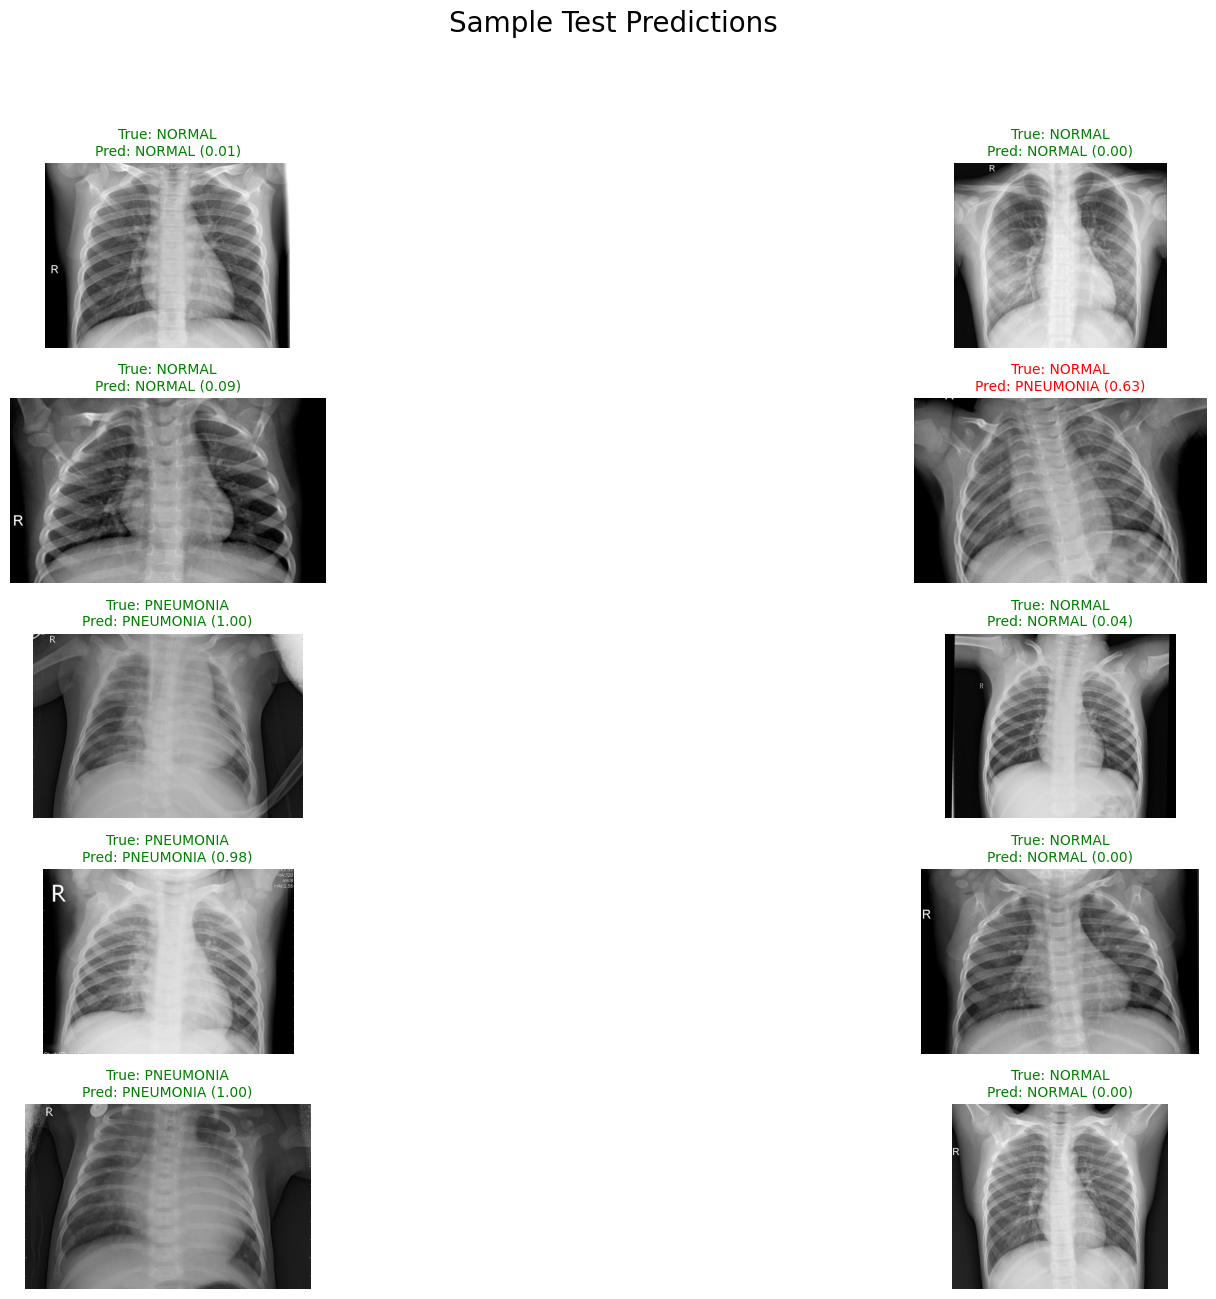

Sample Predictions plot saved to ../results\sample_predictions.png
----------------------------------------


In [10]:
# 7.4. Visualize Sample Predictions (Optional but good for qualitative analysis)
print("\n--- Visualizing Sample Predictions ---")

# Create a sub-directory for sample predictions
sample_pred_dir = os.path.join(results_dir, 'sample_predictions')
os.makedirs(sample_pred_dir, exist_ok=True)

# Select a few random samples from the test set for visualization
num_samples_to_show = 10
indices = np.random.choice(len(test_generator.filenames), num_samples_to_show, replace=False)

plt.figure(figsize=(18, num_samples_to_show * 1.5))
plt.suptitle('Sample Test Predictions', fontsize=20, y=1.02)

for i, idx in enumerate(indices):
    img_path = os.path.join(test_dir, test_generator.filenames[idx])
    true_label = class_names[y_true[idx]]
    predicted_label = class_names[y_pred[idx]]
    predicted_prob = y_pred_probs[idx][0] # Assuming single value for binary output

    img = Image.open(img_path).convert('RGB') # Ensure 3 channels for display
    
    color = "green" if true_label == predicted_label else "red"
    title_text = f"True: {true_label}\nPred: {predicted_label} ({predicted_prob:.2f})"

    ax = plt.subplot(num_samples_to_show // 2 + 1, 2, i + 1) # Adjust subplot grid based on num_samples
    plt.imshow(img)
    plt.title(title_text, color=color, fontsize=10)
    plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.98])
sample_pred_save_path = os.path.join(results_dir, 'sample_predictions.png')
plt.savefig(sample_pred_save_path)
plt.show()
print(f"Sample Predictions plot saved to {sample_pred_save_path}")
print("-" * 40)


In [11]:
# --- 8. Final Summary and Discussion ---
print("\n--- Final Model Evaluation Summary ---")

print("\n**1. Overall Performance:**")
print(f"The model achieved an AUC score of {roc_auc:.2f} on the test set, indicating strong discriminatory power.")
print("The classification report provides detailed metrics for each class.")

print("\n**2. Key Metrics Interpretation (from Classification Report):**")
print("   - **Accuracy:** The overall proportion of correctly classified images.")
print("   - **Precision (Positive Predictive Value):** For 'Pneumonia', it's the percentage of correctly identified pneumonia cases out of all cases predicted as pneumonia. High precision reduces False Positives.")
print("   - **Recall (Sensitivity, True Positive Rate):** For 'Pneumonia', it's the percentage of correctly identified pneumonia cases out of all *actual* pneumonia cases. High recall reduces False Negatives.")
print("   - **F1-Score:** The harmonic mean of precision and recall. A good balance between the two.")
print("   - **Macro Avg & Weighted Avg:** Consider these to understand overall performance, especially with imbalance.")

print("\n**3. Insights from Confusion Matrix:**")
print("   - **True Positives (TP):** Correctly identified 'Pneumonia' cases.")
print("   - **True Negatives (TN):** Correctly identified 'Normal' cases.")
print("   - **False Positives (FP):** 'Normal' cases incorrectly identified as 'Pneumonia'. (Type I error)")
print("   - **False Negatives (FN):** 'Pneumonia' cases incorrectly identified as 'Normal'. (Type II error)")
print("   - For medical diagnosis (like pneumonia), **False Negatives are generally more critical** (missing a disease could be harmful). You want high Recall for the 'Pneumonia' class. However, high False Positives can lead to unnecessary follow-up tests.")

print("\n**4. ROC Curve & AUC:**")
print("   - The ROC curve shows the trade-off between True Positive Rate and False Positive Rate at various threshold settings.")
print("   - An AUC close to 1.0 indicates excellent discriminative ability (the model can distinguish between positive and negative classes well).")

print("\n**5. Training History:**")
print("   - The training history plots (accuracy and loss) show how well the model learned over epochs and indicate if overfitting occurred (e.g., training loss decreases while validation loss increases).")
print("   - The small validation set often leads to highly volatile or deceptively good validation metrics, making the test set evaluation most critical.")

print("\n**6. Impact of Class Imbalance:**")
print("   - The class weights helped the model learn from the minority 'Normal' class effectively, but always scrutinize the metrics for both classes to ensure balanced performance on test data.")

print("\n**7. Potential Improvements & Next Steps:**")
print("   - **Hyperparameter Tuning:** Systematically vary learning rates, batch sizes, number of unfrozen layers, or optimizer settings.")
print("   - **Further Data Augmentation:** Experiment with more aggressive or specialized medical image augmentation (e.g., contrast limited adaptive histogram equalization - CLAHE, elastic deformation, if relevant libraries are available).")
print("   - **Ensemble Methods:** Combine predictions from multiple models.")
print("   - **Different Pre-trained Models:** Experiment with other powerful CNNs (e.g., EfficientNetB0, DenseNet121).")
print("   - **Cross-Validation:** For a more robust evaluation, especially with limited data, K-Fold Cross-Validation could be applied to the training set (though more complex to implement in a two-week project).")
print("   - **Explainability (Grad-CAM):** Implement Grad-CAM to visualize which parts of the X-ray images the model focuses on when making predictions. This is highly valuable for medical imaging and can significantly enhance your project for internships.")

print("\n--- Evaluation Complete ---")


--- Final Model Evaluation Summary ---

**1. Overall Performance:**
The model achieved an AUC score of 0.97 on the test set, indicating strong discriminatory power.
The classification report provides detailed metrics for each class.

**2. Key Metrics Interpretation (from Classification Report):**
   - **Accuracy:** The overall proportion of correctly classified images.
   - **Precision (Positive Predictive Value):** For 'Pneumonia', it's the percentage of correctly identified pneumonia cases out of all cases predicted as pneumonia. High precision reduces False Positives.
   - **Recall (Sensitivity, True Positive Rate):** For 'Pneumonia', it's the percentage of correctly identified pneumonia cases out of all *actual* pneumonia cases. High recall reduces False Negatives.
   - **F1-Score:** The harmonic mean of precision and recall. A good balance between the two.
   - **Macro Avg & Weighted Avg:** Consider these to understand overall performance, especially with imbalance.

**3. Insight